In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import viscid
from viscid.plot import vpyplot as vlt
import numpy as np
#import seaborn as sns
viscid.calculator.evaluator.enabled = True

matplotlib.rcParams['figure.figsize'] = (8, 8)

import scipy.constants as constants
mu0 = constants.mu_0
eps0 = constants.epsilon_0
mi = constants.proton_mass
me = constants.electron_mass
c = constants.c
e = constants.e
kB = constants.k
#matplotlib.style.use('ggplot')
#%config InlineBackend.figure_format = 'retina'

In [6]:
 #Point to directory with the data 
project_dir4="~/UNH/data_m400/"  # 400 mass ratio
project_dir1="~/UNH/data_m100/"  # 100 mass ratio

# Point to single .xdmf file within directory for sim data 
run4 = project_dir4+"/pfd.xdmf"  # mi/me = 400
run1 = project_dir1+"/pfd.xdmf"  # mi/me = 100

# Loas data from a run
vf = viscid.load_file(run1, force_reload=True)


In [7]:
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(50,3*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(371, 0, color = 'k')
        #plt.scatter(280,0,color = 'k')
        #vlt.plot(vf["psi"],style="contour",levels=300,colors='k', ax=ax[i], **kwargs);






# Convenient plotting fuction
def plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(10,3.5*len(fldnames)))
    #if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):

        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        
        vlt.plot(vf[fldname], ax=ax[i], **kwargs);
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)



#  Field interpolation (useful for getting fld value at a chosen coordinate)      
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]

               
# Gets E and B fields at a chosen coordinate
def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # Resets the y position to zero (2D sim so fields don't vary along y)
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B


pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,371,371,371,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]
# Right now this is specific to the mms_Kg211 run being used
def Em_Evolve(pts, run):
    t = 0
    vf = viscid.load_file(run, force_reload=True)
    var = np.zeros([31,2])
    while t<31:
        vf.activate_time(t)
        E,B = Get_Fields(np.array([pts[t],0,0]))
        var[t] = [t,E[1]] 
        
        t += 1
        
    return var


def make_vec(a,b,c):
    fld = viscid.empty(a.crds,nr_comps=3)
    
    fld['x'] = a
    fld['y'] = b
    fld['z'] = c
    
    fld = fld['y=0j']
    
    return fld



def Activate(run, time):
    vf = viscid.load_file(run, force_reload=True)
    t = time
    vf.activate_time(t)
    a = vf["hx_fc"]
    x,y,z = a.crds.get_crds_nc()
    dx,dy,dz = a.crds.get_dx()
        
    # E&B Fields
    Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
    Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
    E = make_vec(Ex,Ey,Ez)
    B = make_vec(Bx,By,Bz)

    B_mag = (Bx**2 + By**2 + Bz**2)**0.5
    E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

    EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
    EPerp = E_mag - EPar

    # Current densities
    jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
    jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
    je = make_vec(jx_e,jy_e,jz_e)
    ji = make_vec(jx_i,jy_i,jz_i)

    J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
    Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

    JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
    #JPerp = J_mag - JPar
    JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
    #JePerp = Je_mag - JePar

    # Velocities
    vex = jx_e / vf["rho_nc_e"]
    vey = jy_e / vf["rho_nc_e"]
    vez = jz_e / vf["rho_nc_e"]
    vix = jx_i / vf["rho_nc_i"]
    viy = jy_i / vf["rho_nc_i"]
    viz = jz_i / vf["rho_nc_i"]
    ve = make_vec(vex,vey,vez)
    vi = make_vec(vix,viy,viz)

    # Non-ideal E Fields
    Ex_prime = Ex  + vey*Bz - vez*By
    Ey_prime = Ey  + vez*Bx - vex*Bz
    Ez_prime = Ez  + vex*By - vey*Bx
    E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

    # Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
    uE = (Ex**2 + Ey**2 + Ez**2)/2
    uB = (Bx**2 + By**2 + Bz**2)/2
        # ## Maybe 

    # Number densities (related to charge density parameter)
    ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

    nq = "nq = rho_nc_e + rho_nc_i"

    # Temperatures
    # Divide by three?  or no?
    Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
    Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

    Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
    Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

    Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
    Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

    Te_Par = (Tex*(Bx**2) +Tey*(By**2) + Tez*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Ti_Par = (Tix*(Bx**2) +Tiy*(By**2) + Tiz*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
    Te_Perp = Te - Te_Par 
    Ti_Perp = Ti - Ti_Par 


    # Poynting Flux
    Sx = (Ey*Bz - Ez*By)/mu0
    Sy = (Ez*Bx - Ex*Bz)/mu0
    Sz = (Ex*By - Ey*Bx)/mu0
    S = make_vec(Sx,Sy,Sz)


    # Kinetic Energy Flux
    #
    #
    #

    # J.E Contributions
    JEx = (jx_e + jx_i)*Ex
    JEy = (jy_e + jy_i)*Ey
    JEz = (jz_e + jz_i)*Ez
    JE = JEx + JEy + JEz

    JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez

    return E, B, S


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

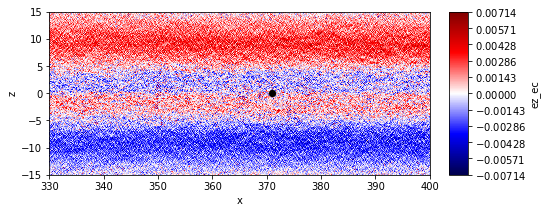

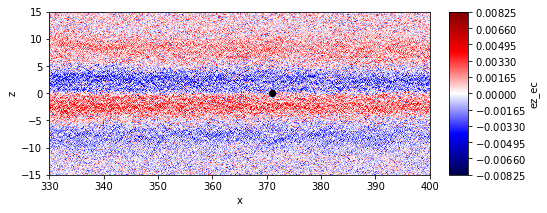

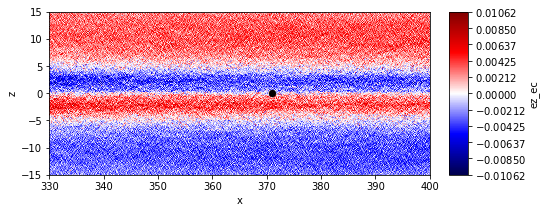

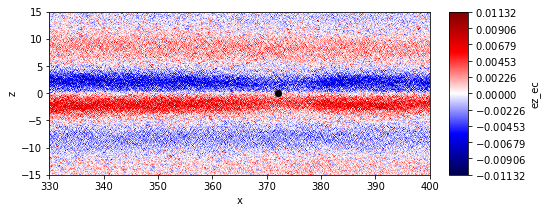

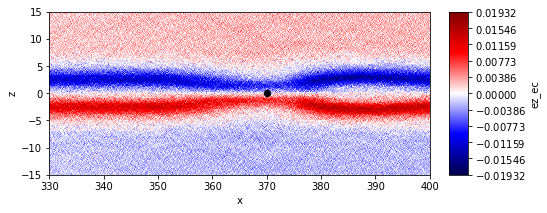

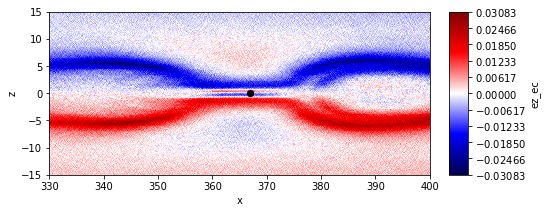

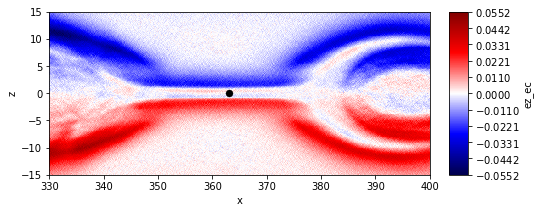

In [8]:
pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]


t = 6
EyPrime_e = "Ey' = ey_ec + (jz_nc_e * hx_fc)/rho_nc_e - (jx_nc_e * hz_fc)/rho_nc_e "
while t < 19:
    make_plot(t, run1, ["ez_ec"],cmap = 'seismic',symmetric=True, selection = "x=330f:400f, z=-15f:15f")
    plt.scatter(pts1[t], 0, color = 'k', s = 50)
    t+=2

In [10]:
#Evaluates the terms in Poynting's theorem at different coordinates for each timestep so we can follow the EDR as the xline evolves

pts1 = [371,371,371,371,371,371,371,371,371,371,371,371,372,371,370,369,367,365,363,359,357,358,358,360,370,376,380,388,395,399,400]


def Evolve(pts):
    ERx = [None]*30
    dERx = [None]*30
    
    for t in range(30):
        
        vf = viscid.load_file(run1, force_reload=True)
        vf.activate_time(t)
        a = vf["hx_fc"]
        x, y, z = a.crds.get_crds_nc()

        # E&B Fields
        Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
        Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]

        # Current densities
        jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
        jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
        
        # Velocities
        vex = jx_e / vf["rho_nc_e"]
        vey = jy_e / vf["rho_nc_e"]
        vez = jz_e / vf["rho_nc_e"]
        vix = jx_i / vf["rho_nc_i"]
        viy = jy_i / vf["rho_nc_i"]
        viz = jz_i / vf["rho_nc_i"]


        # Non-ideal E Fields
        Ex_prime = Ex  + vey*Bz - vez*By
        Ey_prime = Ey  + vez*Bx - vex*Bz
        Ez_prime = Ez  + vex*By - vey*Bx
        
        dx, dy, dz = a.crds.get_dx()

       
        ERx[t] = viscid.interp(Ey_prime, np.array([pts[t],0,0]))
    
    dERx[0] = 0
    dERx[29] = 0
    for t in range(28):
        dERx[t+1] = 0.5*(ERx[t+2] - ERx[t])
        #dERx[t+1] = 0.5*(ERx[t+1] + ERx[t+2]) - 0.5*(ERx[t+1] + ERx[t]) 
    return ERx, dERx


#pt = np.array([340, 0, 0])
ERx, dERx = Evolve(pts1)

#JdotE_edg,Div_S_edg,du_edg = Poynts_Evolve(pts2)


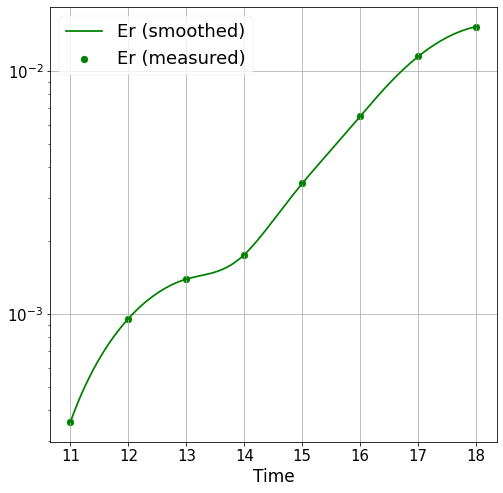

In [130]:
from scipy.interpolate import make_interp_spline
start = 11
stop  = 19
times = list(range(start,stop))
#plt.plot(times, np.abs(ERx[10:]), marker = 'o')
plt.figure(figsize=(8,8))
#plt.plot(times, ERx[start:stop], marker = 'o', color = 'g', label = 'Er')

# Interpolating in between points for smoother line
X_Y_Spline = make_interp_spline(times,ERx[start:stop])
X_ = np.linspace(np.min(times), np.max(times), 1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, color = 'g', label = 'Er (smoothed)')




plt.scatter(times, ERx[start:stop], marker = 'o', color = 'g', label = 'Er (measured)')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('E Rx', fontsize=17)
plt.legend(loc='upper left', prop={'size': 18})

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

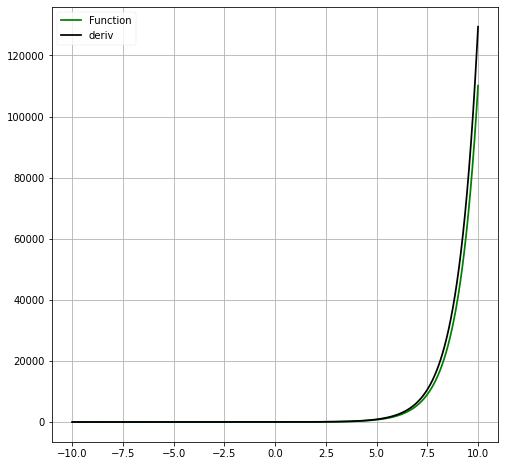

In [71]:
from scipy.misc import derivative
a = 5
def function(x):
    return a*np.exp(x)

def deriv(x):
    return derivative(function,x)

x = np.linspace(-10,10, 1000)

plt.plot(x,function(x), color = 'g', label = 'Function')
plt.plot(x, deriv(x), color = 'k', label = 'deriv')
plt.yscale('linear')

plt.legend(loc='upper left')
plt.grid(True)


Text(0.5, 0, 't')

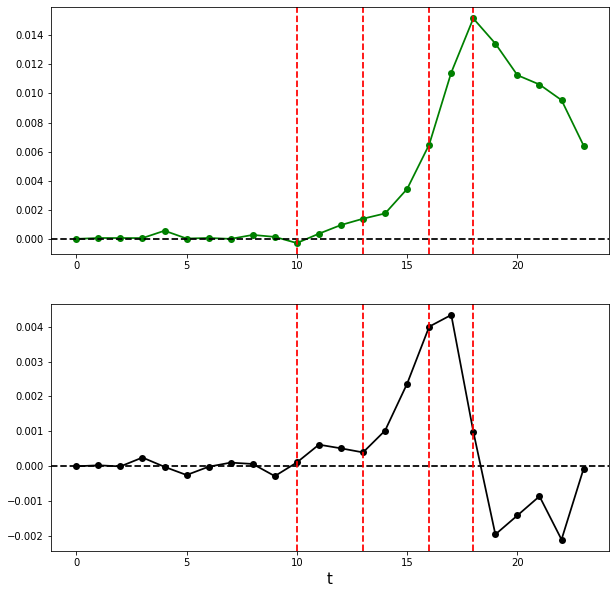

In [34]:
# Plot out-of-plane Efield over time
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)



start = 0
stop = 24
times = list(range(start,stop))

plt.plot(ERx[start:stop], marker = 'o', color = 'g')
plt.yscale('linear')
plt.axhline(y=0, color = 'k',linestyle = '--')
plt.axvline(x=10-start, color = 'r',linestyle = '--')
plt.axvline(x=13-start, color = 'r',linestyle = '--')
plt.axvline(x=16-start, color = 'r',linestyle = '--')
plt.axvline(x=18-start, color = 'r',linestyle = '--')
#plt.axvline(x=18, color = 'r',linestyle = '--')


#plt.ylabel('Em_prime')


plt.subplot(2,1,2)
plt.plot(dERx[start:stop], marker = 'o',color = 'k')
plt.axhline(y=0, color = 'k',linestyle = '--')
plt.axvline(x=10-start, color = 'r',linestyle = '--')
plt.axvline(x=13-start, color = 'r',linestyle = '--')
plt.axvline(x=16-start, color = 'r',linestyle = '--')
plt.axvline(x=18-start, color = 'r',linestyle = '--')
#plt.axvline(x=18, color = 'r',linestyle = '--')


#plt.ylabel('delta Em_prime')




plt.xlabel('t', fontsize = 15)

In [64]:

vf = viscid.load_file(run1, force_reload=True)
run = run1 #run1 or run4
t = 16
vf.activate_time(t)
a = vf["hx_fc"]
x,y,z = a.crds.get_crds_nc()
dx,dy,dz = a.crds.get_dx()
    
# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]
E = make_vec(Ex,Ey,Ez)
B = make_vec(Bx,By,Bz)

B_mag = (Bx**2 + By**2 + Bz**2)**0.5
E_mag = (Ex**2 + Ey**2 + Ez**2)**0.5

EPar = (Ex*Bx + Ey*By * Ez*Bz) / B_mag
EPerp = E_mag - EPar

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]
je = make_vec(jx_e,jy_e,jz_e)
ji = make_vec(jx_i,jy_i,jz_i)

J_mag = ((jx_e + jx_i)**2 + (jy_e + jy_i)**2 + (jz_e + jz_i)**2)**0.5
Je_mag = (jx_e**2 + jy_e**2 + jz_e**2)**0.5

JPar = ((jx_e+jx_i)*Bx + (jy_e+jy_i)*By + (jz_e+jz_i)*Bz)/B_mag
#JPerp = J_mag - JPar
JePar = (jx_e*Bx + jy_e*By + jz_e*Bz)/B_mag
#JePerp = Je_mag - JePar

# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]
ve = make_vec(vex,vey,vez)
vi = make_vec(vix,viy,viz)

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx
E_prime = make_vec(Ex_prime, Ey_prime, Ez_prime)

# Field Energy Densities (not sure what to put as factor, so can't compare magnitudes)
uE = (Ex**2 + Ey**2 + Ez**2)/2
uB = (Bx**2 + By**2 + Bz**2)/2
    # ## Maybe 

# Number densities (related to charge density parameter)
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

nq = "nq = rho_nc_e + rho_nc_i"

# Temperatures
# Divide by three?  or no?
Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"]
Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]

Tee = make_vec(Tex, Tey, Tez) #  IMPORTANT NOTE: These are not really vector components...
Tii = make_vec(Tix, Tiy, Tiz) #           .....they are diagonal terms in temp tensors

Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3

#Careful when calculating T_Perp.  You'll get negative vals if the factor of 1/3 is only on Te

Te_Par = (Tex*np.abs(Bx) +Tey*np.abs(By) + Tez*np.abs(Bz)) / 3*B_mag 
Te_Perp = Te - Te_Par 

Te_ParPerp = Te_Par/Te_Perp - 1


# Poynting Flux
Sx = (Ey*Bz - Ez*By)/mu0
Sy = (Ez*Bx - Ex*Bz)/mu0
Sz = (Ex*By - Ey*Bx)/mu0
S = make_vec(Sx,Sy,Sz)


# Kinetic Energy Flux
#
#
 #

 # J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez
JE = JEx + JEy + JEz

JEe = jx_e*Ex + jy_e*Ey + jz_e*Ez



 # Poynting's Theorem Terms
#divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
#JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
#JE_alt = JEx + JEy + JEz
#dudt = -JE - divS



#vlt.plot(JEe - JePar*EPar,cmap = "seismic", symmetric=True, cbarlabel = " ", selection ="x=330f:400f, z=-15f:15f ")


In [45]:
# Vector Plotting

#plt.figure(figsize=(20, 20))
#vlt.plot(E['x'], cmap = "seismic", symmetric = "True",cbarlabel="Ey_prime")
#Q = vlt.plot2d_quiver(E_prime['x=::10, z=::10'],step = 1 ,scale = 750)
#plt.xlim(330,400)
#plt.ylim(-20,20)
#fnt = 25
#plt.xticks(fontsize=fnt)
#plt.yticks(fontsize=fnt)
#plt.xlabel('x', fontsize=fnt)
#plt.ylabel('z', fontsize=fnt)
#vlt.auto_adjust_subplots()

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

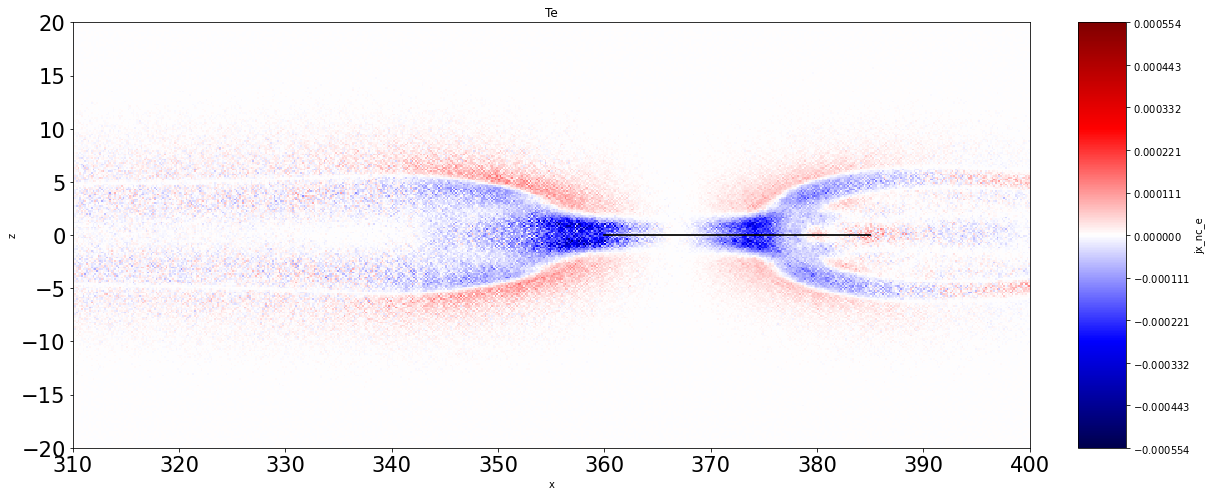

In [66]:
# Make 1D cuts to look at data along cut

#pt0 = (pts1[t], 0, -20) # x,y,z coords for beginning and end of a line in domain 
#pt1 = (pts1[t], 0, 20)
pt0 = (360, 0, 0) # x,y,z coords for beginning and end of a line in domain 
pt1 = (385, 0, 0)
npts = 1000         # number of measurements along line between pt0 and pt1
#frame = 80
seeds = viscid.seed.Line(pt0, pt1, npts)
seed_pts = seeds.get_points()
fnt = 21 #axis fontsizes


# Make colorplot
plt.figure(figsize=(20,7))
plt.subplot(1,1,1)
vlt.plot(JEx, cmap = "seismic", symmetric = True, title = 'Te')
plt.axis("image")
plt.xlim(310,400)
plt.ylim(-20,20)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)




plt.plot(seed_pts[0,:], seed_pts[2,:], color = 'k')




vlt.tighten() #No idea what this does

In [16]:
pt0[0]
pt1[0]

363

In [9]:

E14, B14, S14 = Activate(run1,14)
E15, B15, S15 = Activate(run1,15)
E16, B16, S16 = Activate(run1,16)
E17, B17, S17 = Activate(run1,17)
E18, B18, S18 = Activate(run1,18)
E19, B19, S19 = Activate(run1,19)
E20, B20, S20 = Activate(run1,20)

Text(0.5, 0, 'Tracing distance')

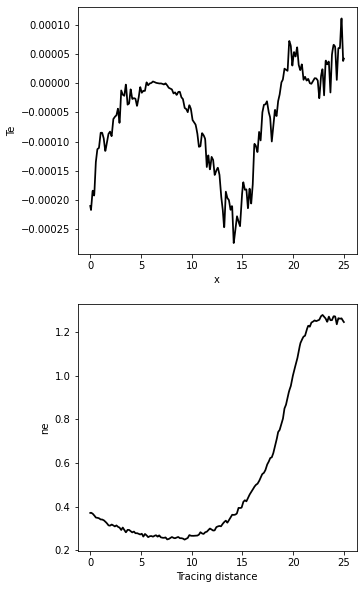

In [67]:
# Makes the line (?) and coords along it corresponding to data in plot (?)


# Make plot of fld value along line
fig, ax = plt.subplots(2,1,figsize=(5,10))
#vlt.plot(viscid.interp_trilin(S['x'], seeds), color = 'b', label = 'Sx') # Links coordinate of line to value of fld at that coordinate
#vlt.plot(viscid.interp_trilin(S['y'], seeds), color = 'g', label = 'Sy') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(JEx, seeds), ax=ax[0], color = 'k', label = 'Te') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(ne, seeds), ax = ax[1], color = 'k', label = 'ne') # Links coordinate of line to value of fld at that coordinate
#plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
#plt.legend(prop={'size': 18})
#plt.xticks(fontsize=fnt)
#plt.yticks(fontsize=fnt)

plt.xlabel("Tracing distance")


Text(0.5, 0, 'Tracing distance')

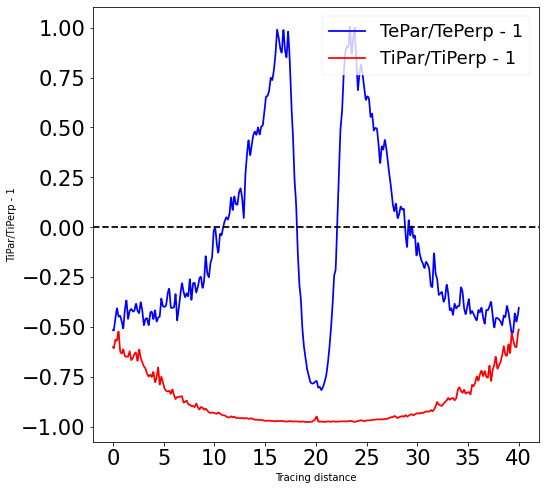

In [149]:
# Make plot of fld value along line
plt.subplot(1,1,1)
vlt.plot(viscid.interp_trilin(Te_Par/Te_Perp - 1, seeds), color = 'b', label = 'TePar/TePerp - 1') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(Ti_Par/Ti_Perp - 1, seeds), color = 'r',label = 'TiPar/TiPerp - 1')
plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.xlabel("Tracing distance")
